In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
def plot_history(history):
  cum_rewards = history["cum_rewards"]
  chosen_arms = history["arms"]

  fig = plt.figure(figsize=[30,8])

  ax2 = fig.add_subplot(121)
  ax2.plot(cum_rewards, label="avg rewards")
  ax2.set_title("Cummulative Rewards")

  ax3 = fig.add_subplot(122)
  ax3.bar([i for i in range(len(chosen_arms))], chosen_arms, label="chosen arms")
  ax3.set_title("Chosen Actions")

In [3]:
# create an environment for the agent to interact with
class env(object):
    def __init__(self, mean, std):
        if len(mean)!=len(std):
            raise ValueError('mean and std must have the same length')
        self.mean = mean
        self.std = std
        self.k_arms = len(mean)
    
    def pull(self, arm):
        if arm not in range(self.k_arms):
            raise ValueError(f"arm {arm} must be in range of k_arms")
        return np.random.normal(self.mean[arm], self.std[arm])


In [22]:
environment = env([1,2,3,4,5,6,7,8], [8,7,6,5,4,3,2,1])

In [23]:
class RandomAgent(object):

  def __init__(self, env, max_iterations=2000):
    self.env = env
    self.iterations = max_iterations

  def act(self):
    arm_counts = np.zeros(self.env.k_arms)
    rewards = []
    cum_rewards = []

    for i in range(1, self.iterations + 1):
      arm = np.random.choice(self.env.k_arms)
      reward = self.env.pull(arm)

      arm_counts[arm] += 1
      rewards.append(reward)
      cum_rewards.append(sum(rewards)/ len(rewards))

    return {"arms": arm_counts, "rewards": rewards, "cum_rewards": cum_rewards}

In [24]:
random_agent = RandomAgent(env=environment, max_iterations=2**13)
ra_history = random_agent.act()
print(f"TOTAL REWARD : {sum(ra_history['rewards'])}")

TOTAL REWARD : 37097.768926399105


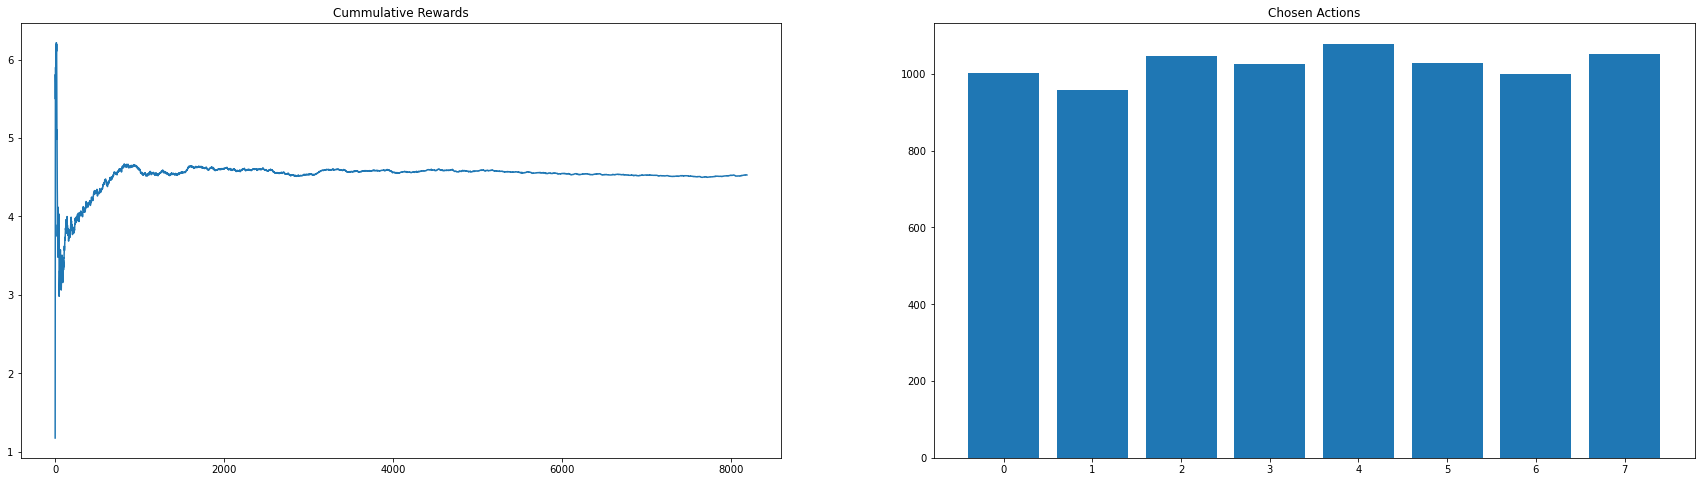

In [25]:
plot_history(ra_history)

In [8]:
class EpsilonGreedyAgent(object):

  def __init__(self, env, max_iterations=200, epsilon=0.01, decay=0.001, decay_interval=50):
    self.env = env 
    self.iterations = max_iterations
    self.epsilon = epsilon 
    self.decay = decay 
    self.decay_interval = decay_interval

  def act(self):
    q_values = np.zeros(self.env.k_arms)
    arm_rewards = np.zeros(self.env.k_arms)
    arm_counts = np.zeros(self.env.k_arms)

    rewards = []
    cum_rewards = []

    for i in range(1, self.iterations + 1):
      arm = np.random.choice(self.env.k_arms) if np.random.random() < self.epsilon else np.argmax(q_values)
      reward = self.env.pull(arm)

      arm_rewards[arm] += reward
      arm_counts[arm] += 1
      q_values[arm] = arm_rewards[arm]/arm_counts[arm]

      rewards.append(reward)
      cum_rewards.append(sum(rewards)/ len(rewards))

      if i % self.decay_interval == 0:
        self.epsilon = self.epsilon * self.decay 

    return {"arms": arm_counts, "rewards": rewards, "cum_rewards": cum_rewards}


In [31]:
egreedy_agent = EpsilonGreedyAgent(environment, max_iterations=2**13, epsilon=0.05, decay=1)
eg_history = egreedy_agent.act()
print(f"TOTAL REWARD : {sum(eg_history['rewards'])}")

TOTAL REWARD : 64043.2184061198


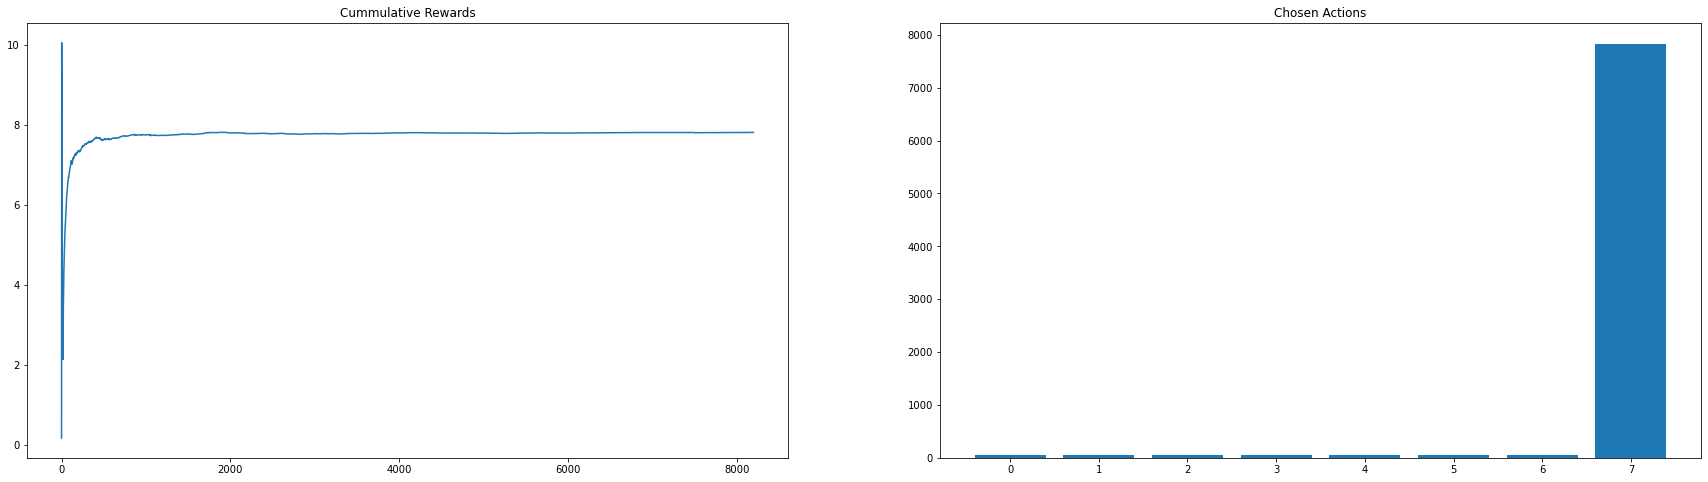

In [32]:
plot_history(eg_history)

In [19]:
# implement Sequential Halving
class SeqHalf(object):
    def __init__(self, env, time = 2**13):
        self.env = env
        self.time = time

    def act(self):
        arms = self.env.k_arms
        rounds = int(np.log2(arms))
        best_arms = np.array([i for i in range(arms)])
        arm_counts = np.zeros(arms)

        rewards = []
        cum_rewards = []
        for i in range(rounds):
            arm_rewards = np.zeros(arms)
            r_time = self.time//(rounds*len(best_arms))
            for j in range(r_time):
                for k in best_arms:
                    reward = self.env.pull(k)
                    arm_rewards[k] += reward
                    arm_counts[k] += 1
                    rewards.append(reward)
                    cum_rewards.append(sum(rewards)/ len(rewards))
            arm_rewards = arm_rewards/r_time
            print(arm_rewards)
            # select best half arms
            best_arms = np.argsort(arm_rewards)[::-1][:len(best_arms)//2]
            print(best_arms)
        return {"arms": arm_counts, "rewards": rewards, "cum_rewards": cum_rewards}

In [33]:
seqhalf_agent = SeqHalf(environment)
sh_history = seqhalf_agent.act()
print(f"TOTAL REWARD : {sum(sh_history['rewards'])}")

[1.06397902 2.2333701  2.83101147 4.50042943 5.1471501  6.26783169
 7.19363403 7.94643883]
[7 6 5 4]
[0.         0.         0.         0.         4.8563898  5.93485916
 7.09859106 8.01324467]
[7 6]
[0.         0.         0.         0.         0.         0.
 6.93433838 8.02459643]
[7]
TOTAL REWARD : 50764.54080087601


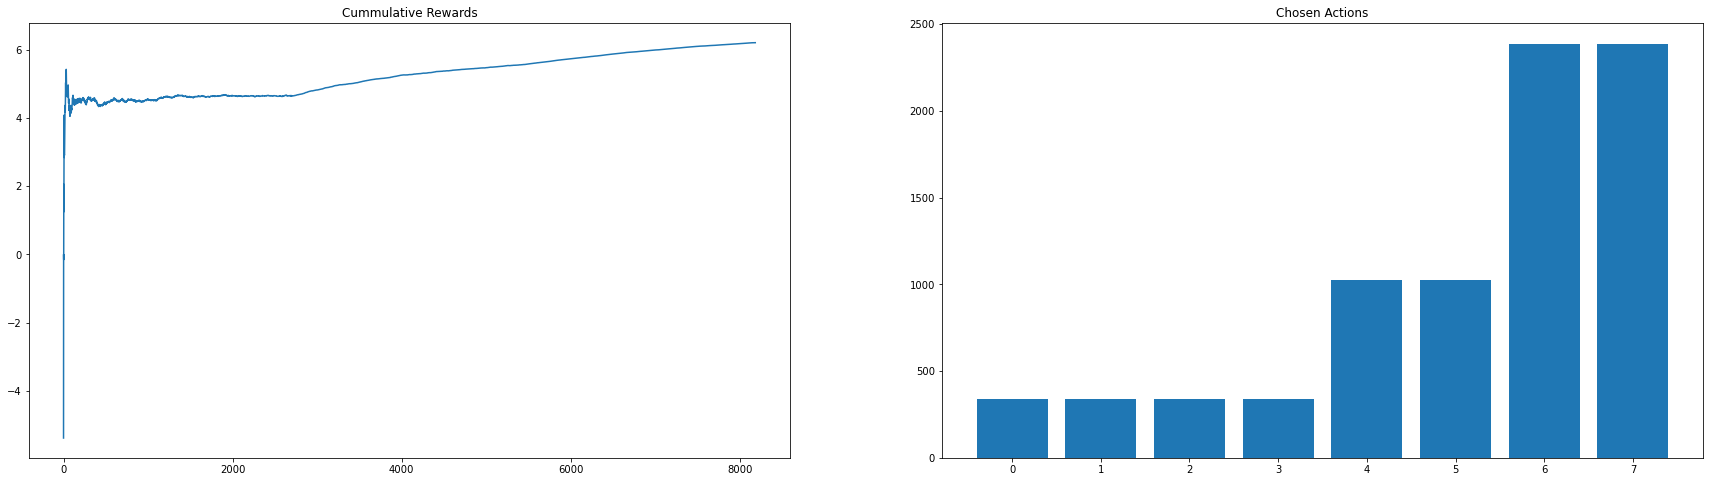

In [34]:
plot_history(sh_history)

In [63]:
class config():
    arms = 16
    mean_dist = [i+1 for i in range(arms)]
    std = [1 for i in range(arms)]
    time = 2**13
    chng_arm = 2
    chng_time = np.random.randint(0, time)
    # chng_time = 2**2
    new_mean = max(mean_dist) + 1
    new_mean_dist = [i+1 for i in range(arms)]
    new_mean_dist[chng_arm] = new_mean

In [82]:
class SeqHalf_with_change(object):
    def __init__(self, config, env,chng_time):
        self.config = config
        self.env = env
        self.time = config.time
        self.chng_arm = config.chng_arm
        self.chng_time = chng_time
        self.mean_dist = config.mean_dist
        self.new_mean_dist = config.new_mean_dist
        self.std = config.std

    def act(self):
        env1 = env(self.mean_dist, self.std)
        env2 = env(self.new_mean_dist, self.std)
        arms = env1.k_arms
        rounds = int(np.log2(arms))
        best_arms = np.array([i for i in range(arms)])
        arm_counts = np.zeros(arms)
        chng_time = self.chng_time
        t=0

        rewards = []
        cum_rewards = []
        for i in range(rounds):
            arm_rewards = np.zeros(arms)
            r_time = self.time//(rounds*len(best_arms))
            for j in range(r_time):
                for k in best_arms:
                    if t < chng_time:
                        reward = env1.pull(k)
                    else:
                        reward = env2.pull(k)
                    t+=1
                    arm_rewards[k] += reward
                    arm_counts[k] += 1
                    rewards.append(reward)
                    cum_rewards.append(sum(rewards)/ len(rewards))
            arm_rewards = arm_rewards/r_time
            # select best half arms
            best_arms = np.argsort(arm_rewards)[::-1][:len(best_arms)//2]
        print(best_arms)
        return {"arms": arm_counts, "rewards": rewards, "cum_rewards": cum_rewards}

In [84]:
for i in range(1024, 2048, 128):
    seqhalf_chng_agent = SeqHalf_with_change(config, env, i)
    print(i)
    sh_chng_history = seqhalf_chng_agent.act()
    # print(f"TOTAL REWARD : {sum(sh_chng_history['rewards'])}")

1024
[2]
1152
[2]
1280
[15]
1408
[15]
1536
[15]
1664
[15]
1792
[15]
1920
[15]


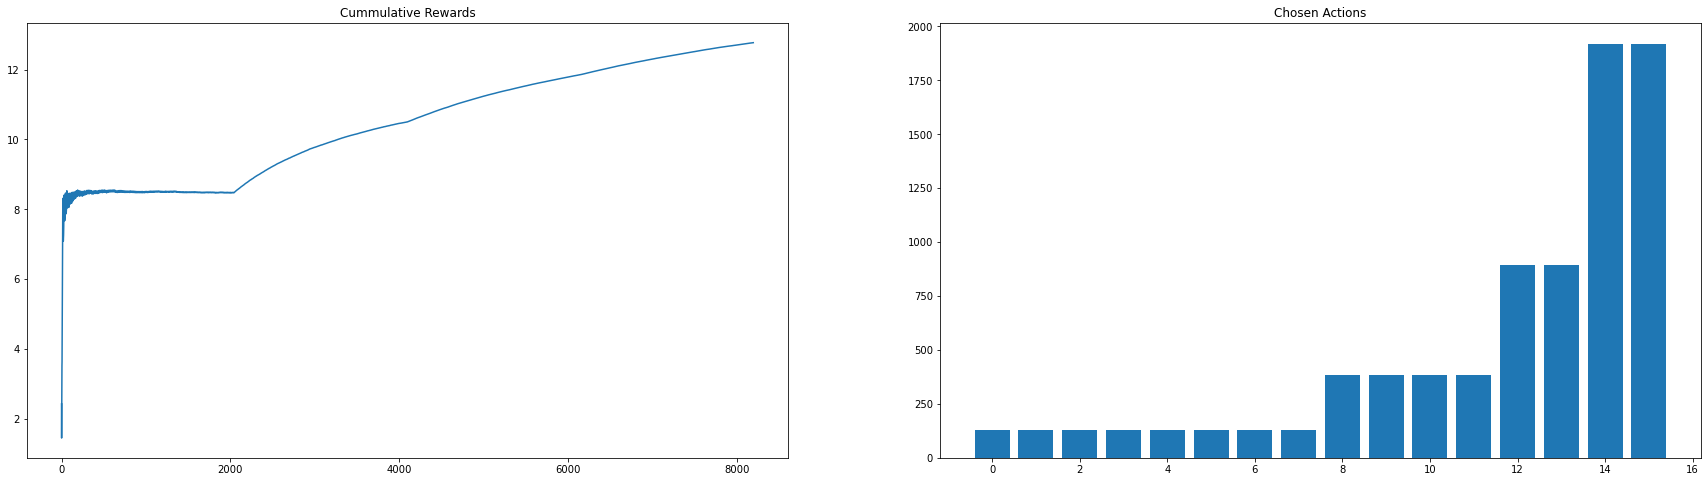

In [59]:
plot_history(sh_chng_history)